***Using advanced Monte Carlo Option Pricing models for crypto currencies***

The goal of this project to explore the details of implementing advanced Monte Carlo Option Pricing models that goes beyond limitation of Black-Scholes model and of applying such models to crypto currencies.
Crypto currencies exhibit higher volatility and its variation and sudden moves compare to traditional assets.
I have chosen Stochastic Volatility and Correlated Jumps (SVCJ) model that incorporates several features that make it more realistic for crypto currencies:
1. variable volatility, which is also subject to random dynamic (stochastic volatility)
2. correlated jumps in underlying and in volatility that follow a random process (Poisson process)

We begin with the real-world (or physical) dynamics of the SVCJ model, as specified by Duffie, Pan, and Singleton (2000) and used in the paper by Hou et al. (2020). These equations describe the actual statistical behavior of the asset.

The log-return process, $Y_t = \ln(S_t)$, and the variance process, $V_t$, are given by:

$$dY_t = \left(\mu - \frac{1}{2}V_t\right)dt + \sqrt{V_t}dW_t^{(S)} + Z_t^y dN_t$$
$$dV_t = \kappa(\theta - V_t)dt + \sigma_V\sqrt{V_t}dW_t^{(V)} + Z_t^v dN_t$$
$$Cov(dW_t^{(S)}, dW_t^{(V)}) = \rho dt$$
$$Cov(Z_t^{y}, Z_t^{v}) = \rho_j$$

Here, $W_t^{(S)}$ and $W_t^{(V)}$ are standard Brownian motions under the real-world measure $\mathbf{P}$. The process $N_t$ is a Poisson process with intensity $\lambda$, also under $\mathbf{P}$. The parameter $\mu$ represents the actual expected return of the asset, which includes a risk premium, so typically $\mu > r$. Parameters $\rho$ and $\rho_j$ are the correlation coefficients between the Brownian motions and the Poisson processes.


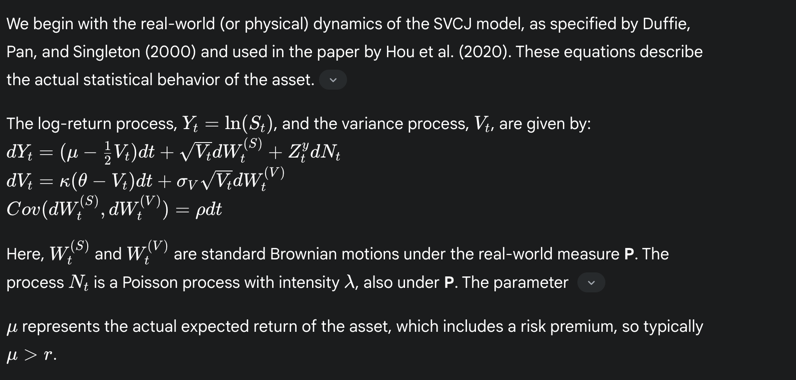
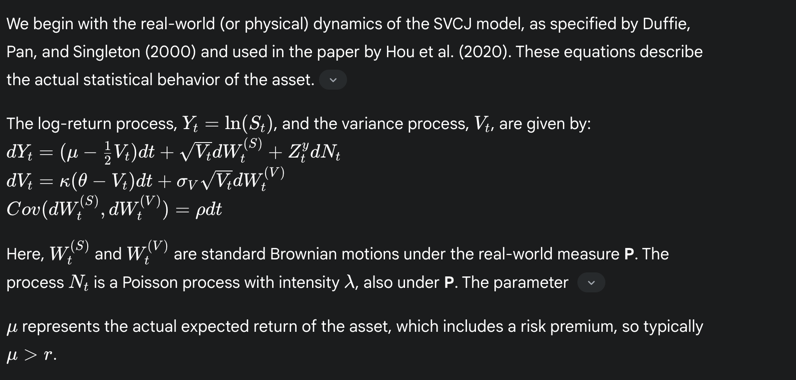

Applying Euler discretization to the above SDEs, we arrive to the following function for simulating the SVCJ dynamics for underlying (P-measure):

In [26]:
import numpy as np
import pandas as pd
from pandas.io.common import file_path_to_url
from scipy import stats as st

#from crypto_exchange_utils import load_prices_to_csv


def simulate_SVCJ_p_measure(params, T_sim, dt):
    """
    Simulates a single path of returns and volatility under the P-measure (real world)
    with the model used for parameter estimation in the paper.
    """
    mu, kappa, theta, sigma_v, rho, lambda_, mu_y, sigma_y, rho_j, mu_v = params

    alpha = kappa * theta
    beta = 1 - kappa

    N_steps = int(T_sim / dt)
    returns = np.zeros(N_steps)
    volatility = np.zeros(N_steps)

    # Initial volatility set to the long-run mean
    volatility[0] = theta

    # Generate correlated random numbers for the Brownian motions
    z1 = np.random.normal(size=N_steps)
    z2 = rho * z1 + np.sqrt(1 - rho ** 2) * np.random.normal(size=N_steps)

    # Generate jump occurrences (Bernoulli process)
    # The jump probability is the only place where dt is used, as lambda is a rate.
    # poisson_shocks = np.random.poisson(lambda_ * dt, N_steps)
    # jumps = poisson_shocks > 0
    jumps = np.random.uniform(0, 1, N_steps) < (lambda_ * dt)

    # Generate volatility jumps (Exponential distribution)
    Z_v = np.random.exponential(mu_v, N_steps)

    # Generate return jumps (Normal distribution, conditional on vol jumps)
    Z_y = np.random.normal(mu_y + rho_j * Z_v, sigma_y, N_steps)

    for t in range(1, N_steps):
        # Ensure non-negative volatility for the sqrt term
        v_prev = max(0, volatility[t - 1])

        # Implements discrete-time volatility update
        # The parameters alpha, beta, and sigma_v are for a single step, so no dt scaling.
        vol_diffusion = sigma_v * np.sqrt(v_prev) * z2[t]
        vol_jump = Z_v[t] * jumps[t]
        volatility[t] = alpha + beta * v_prev + vol_diffusion + vol_jump

        # Implements discrete-time log-return update
        # The parameters mu and the diffusion term are for a single step.
        return_diffusion = np.sqrt(v_prev) * z1[t]
        return_jump = Z_y[t] * jumps[t]
        returns[t] = mu + return_diffusion + return_jump

    return pd.Series(returns)

All parameter notations are in line with the paper by Hou et al. (2020).

## Loading underlying and option data from exchange

We are using ccxt library to load the data from exchange. Below is the helper functions to load the underlying and option data from exchange.

In [237]:
import os
import pathlib
from pathlib import Path
import pandas as pd
import sys
import csv
from pprint import pprint
import datetime
from dotenv import load_dotenv

#from utils import str_to_epoch

load_dotenv()


import ccxt


def str_to_epoch(timestamp_string):
    formats = [
        '%Y-%m-%d',
        '%Y-%m-%dT%H:%M:%S.%f%z',
        '%Y-%m-%dT%H:%M:%S%z',
        '%Y-%m-%d %H:%M:%S.%f%z',
        '%Y-%m-%d %H:%M:%S%z',
        '%Y-%m-%dT%H:%M:%S',
        '%Y-%m-%d %H:%M:%S.%f',
        '%Y-%m-%d %H:%M:%S',
        "%m/%d/%Y %I:%M:%S %p",
        "%m/%d/%Y"
    ]

    for fmt in formats:
        try:
            dt_object = datetime.datetime.strptime(timestamp_string, fmt)
            return int(dt_object.timestamp())
        except ValueError:
            continue

    # If no format matches, raise an error or return a default value
    raise ValueError(f"Unable to parse timestamp: {timestamp_string} with known formats.")



def get_exchange(exchange_id):
    exchange_class = getattr(ccxt, exchange_id)
    api_key = os.environ.get(exchange_id.upper() + '_API_KEY')
    api_secret = os.environ.get(exchange_id.upper() + '_API_SECRET')
    exchange = exchange_class({
        'apiKey': api_key,
        'secret': api_secret,
        'enableRateLimit': True
    })
    return exchange


def fetch_ohlcv_with_retries(exchange,symbol, timeframe, since, limit=20000, max_retries=3):
    num_retries = 0
    try:
        num_retries += 1
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, limit)
        return ohlcv
    except Exception as ex:
        print(ex)
        if num_retries > max_retries:
            raise ex


def load_ohlcv(exchange, symbol, timeframe, since = '2025-01-01', limit=20000, max_retries=3):
    earliest_timestamp = exchange.milliseconds()
    timeframe_duration_in_seconds = exchange.parse_timeframe(timeframe)
    timeframe_duration_in_ms = timeframe_duration_in_seconds * 1000
    timedelta = limit * timeframe_duration_in_ms
    all_ohlcv = []
    if isinstance(since, str):
        since = str_to_epoch(since)*1000

    while True:
        fetch_since = earliest_timestamp - timedelta
        if fetch_since < since:
            fetch_since = since
        ohlcv = fetch_ohlcv_with_retries(exchange, symbol, timeframe, fetch_since, max_retries=max_retries, limit=limit)
        if not ohlcv:
            break
        if ohlcv[0][0] >= earliest_timestamp:
            break
        earliest_timestamp = ohlcv[0][0]
        all_ohlcv = ohlcv + all_ohlcv
        print(len(all_ohlcv), symbol, 'candles in total from', exchange.iso8601(all_ohlcv[0][0]), 'to', exchange.iso8601(all_ohlcv[-1][0]))
        # if we have reached the checkpoint
        if earliest_timestamp <= since:
            break
    return all_ohlcv


def write_to_csv(dirpath: Path, filename, data):
    if isinstance(dirpath, str):
        dirpath = pathlib.Path(dirpath)
    dirpath.mkdir(parents=True, exist_ok=True)
    full_path = dirpath/str(filename)
    with Path(full_path).open('w+', newline='') as output_file:
        csv_writer = csv.writer(output_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerows(data)


def load_prices_to_csv(dirpath, filename, exchange, symbol, timeframe='1d', since='2020-01-01', limit=20000, max_retries=3):
    # instantiate the exchange by id
    # convert since from string to milliseconds integer if needed
    if isinstance(since, str):
        since = str_to_epoch(since)*1000
    # preload all markets from the exchange
    exchange.load_markets()
    # fetch all candles
    ohlcv = load_ohlcv(exchange, symbol, timeframe, since, max_retries=max_retries, limit=limit)
    if ohlcv:
        write_to_csv(dirpath, filename, ohlcv)
        print('Saved', len(ohlcv), 'candles from', exchange.iso8601(ohlcv[0][0]), 'to', exchange.iso8601(ohlcv[-1][0]),
              'to', f"{dirpath}/{filename}")
    else:
        print('No candles found for', symbol, 'from', exchange.iso8601(since), 'to',
              exchange.iso8601(since + limit * exchange.parse_timeframe(timeframe)))
    output_df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    output_df.index = pd.to_datetime(output_df['timestamp'], unit='ms')
    output_df.drop(columns=['timestamp'], inplace=True)
    return output_df



def load_ohlcv_from_csv(file_path)-> pd.DataFrame:
    df = pd.read_csv(file_path)
    df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    return df


Load BTC data for last 5 years into local file:

In [31]:
btc_ohlcv = load_prices_to_csv("./data/binance", "BTC_USDT_binance_since_2000.csv", get_exchange("binance"), "BTC/USDT", "1d", "2020-09-01")
btc_ohlcv.index = pd.to_datetime(btc_ohlcv['timestamp'], unit='ms')
btc_ohlcv.drop(columns=['timestamp'], inplace=True)
btc_ohlcv.head()

1000 BTC/USDT candles in total from 2020-09-01T00:00:00.000Z to 2023-05-28T00:00:00.000Z
Saved 1000 candles from 2020-09-01T00:00:00.000Z to 2023-05-28T00:00:00.000Z to ./data/binance/BTC_USDT_binance_since_2000.csv


,open,high,low,close,volume
timestamp,,,,,
2020-09-01,11649.51,12050.85,11515.0,11921.97,78148.193668
2020-09-02,11921.97,11954.57,11160.1,11388.54,87221.845602
2020-09-03,11388.54,11462.60,9960.8,10140.85,121950.106015
2020-09-04,10138.29,10627.05,9875.5,10446.25,92733.599113
2020-09-05,10446.25,10565.68,9825.0,10166.69,90001.605568


Create log returns from OHLCV data:

In [32]:
btc_log_returns = np.log(btc_ohlcv['close'] / btc_ohlcv['close'].shift(1)).dropna()
btc_log_returns.head()

timestamp
2020-09-02   -0.045775
2020-09-03   -0.116036
2020-09-04    0.029671
2020-09-05   -0.027126
2020-09-06    0.008766
Name: close, dtype: float64

## Distribution analysis

For further comparision and optimisation we will use the generic and autocorrelation moments. The generic moments are the central moments of the returns. $N_{th}$ order standartized moment is defined as
$\mu_{N} = \sum_{i=1}^{N}(x_i - \bar{x})^N/\sigma^N$, where $\sigma$ is the standard deviation of the returns. The first 4 orders of central standartized moments are well-known mean, variance, skewness and kurtosis. We also include autocorrelation moments into our analysis, namely autocorrelation moments of the squared returns. This is a common practice in the literature to capture volatility clustering.

In [35]:
def generic_and_autocorr_moments(log_returns, max_moment_order=4, autocorr_lags=5):
    # this part to handle antithetic case introduced below
    if isinstance(log_returns, tuple) and len(log_returns) ==2:
        return (generic_and_autocorr_moments(log_returns[0], max_moment_order, autocorr_lags) +
                generic_and_autocorr_moments(log_returns[1], max_moment_order, autocorr_lags))/2.0
    # --- Standard Moments ---
    sample_mean = np.mean(log_returns)
    sample_var = np.var(log_returns)
    sample_std = np.sqrt(sample_var)

    moments = []

    for N in range(1, max_moment_order+1):
        if N == 1:
            moments.append(sample_mean)
        elif N == 2:
            moments.append(sample_var)
        else:  # Calculate N-th standardized moment for N > 2
            if sample_std < 1e-12:
                standardized_moment = 0.0
            else:
                # Calculate N-th central moment
                central_moment = np.mean((log_returns - sample_mean) ** N)
                # Standardize it
                standardized_moment = central_moment / (sample_std ** N)
            moments.append(standardized_moment)

    # --- Autocorrelation Moments ---
    squared_returns = log_returns ** 2
    for i in range(1, autocorr_lags + 1):
        autocorr_val = squared_returns.autocorr(lag=i)
        moments.append(0 if np.isnan(autocorr_val) else autocorr_val)

    return np.array(moments)

In [45]:
target_historical_moments = generic_and_autocorr_moments(btc_log_returns, max_moment_order=5, autocorr_lags=3)
def print_moments(moments):
    mean, var, skew, kurt, c4, autocorr_1, autocorr_2, autocorr_3 = moments
    print(f"Historical moments:\n mean: {mean},\n var: {var},\n skewness: {skew},\n kurtosis: {kurt},\n m5: {c4},\n autocorr_1: {autocorr_1},\n autocorr_2: {autocorr_2},\n autocorr_3: {autocorr_3}")

print_moments(target_historical_moments)

Historical moments:
 mean: 0.0008569973292851933,
 var: 0.001292270444979659,
 skewness: -0.20042158122007783,
 kurtosis: 5.879632775803558,
 m5: -3.8768475475006228,
 autocorr_1: 0.08792778942610814,
 autocorr_2: 0.03034259173657919,
 autocorr_3: 0.029635383462502114


## Initial parameter estimations: heuristic approach

We can create initial estimates for the parameters of the SVCJ model using the historical time series of daily log-returns based on meaningful interpretations of the parameters.
### Basic Unconditional Moments: estimates for $\mu$ and $\theta$.


**Method**: Calculate the sample mean of the daily log-returns and annualize it.

**Formula**: _$\mu_initial$ = np.mean(daily_returns) * 252_

$\theta$ (Long-Run Variance):

**Method**: Calculate the sample variance of the daily log-returns and annualize it. This serves as a good proxy for the long-run average variance.

**Formula**: _theta_initial = np.var(daily_returns) * 252_

###  Jump parameters

#### Jump filtering
To approximate the jump parameters, we need a simple way to distinguish "jump days" from "normal days." A common heuristic is to use a standard deviation threshold.

Method:

Calculating the overall standard deviation of daily returns: _std_dev = np.std(daily_returns)_.

Defining a jump as any day where the absolute log-return exceeds a certain threshold, for example, 3 or 4 standard deviations: jump_threshold = 3 * std_dev. Then jump day would be defined by the parameter is_jump_day = np.abs(daily_returns) > jump_threshold.

Filtered jump_return: jump_returns = daily_returns[is_jump_day].

#### Estimating Jump Parameters

Now we use the filtered jump_returns to estimate the jump characteristics.

##### $\lambda$ (Jump Intensity):

**Method**: Counting the number of jump days and express it as an annualized frequency.

**Formula**: _$lambda_initial$ = len(jump_returns) / len(daily_returns) * 252_

##### $mu_y$ (Mean of Price Jump):

**Method**: Calculating the mean of the returns on the identified jump days.

**Formula**: mu_y_initial = np.mean(jump_returns)

$\sigma_y$ (Std. Dev. of Price Jump):

**Method**: Calculating the standard deviation of the returns on the identified jump days.

**Formula**: sigma_y_initial = np.std(jump_returns)

#### Approximate Volatility Dynamics Parameters

For volatility dynamics we can use a simple time-series model like AR(1).

$\kappa$ (Mean Reversion Speed):

**Method**: One can use squared returns (daily_returns**2) as a simple proxy for daily variance. Fitting a simple AR(1) model to this series:
$V_t =  c + \phi V_{t-1} + \epsilon_t$ . The coefficient $\phi$ is related to the discrete-time mean-reversion parameter $\beta =1−\kappa \delta t$ from where we can extract $\kappa$.

**Formula**:

Fit an AR(1) model to daily_returns**2 to get the coefficient ϕ.

$\kappa_initial = (1 - \phi) * 252$

$\sigma_v$ (Volatility of Volatility):

Method: I used the standard deviation of the residuals from the AR(1) model fit above. This measures the unexplained shocks to our variance proxy

Getting the residuals from the AR(1) fit on daily_returns**2 we arrive at:

sigma_v_initial = np.std(residuals) * np.sqrt(252)

$\rho$ (Leverage Effect Correlation):

Method: Calculate the sample correlation between the daily returns and the change in our variance proxy (squared returns). This captures the tendency for returns and volatility shocks to move together.

Formula: rho_initial = np.corrcoef(daily_returns[1:], np.diff(daily_returns**2))

$\mu_v$ (Mean of Volatility Jump):

Method: Calculate the average value of our variance proxy (squared returns) on the identified jump days. This gives a rough idea of the magnitude of a volatility jump.

Formula: mu_v_initial = np.mean(daily_returns[is_jump_day]**2)

$\rho_j$ (Correlation of Jumps):

Method: On the identified jump days, calculate the correlation between the return and the squared return. This proxies the correlation between the price jump and the volatility jump.

Formula: rho_j_initial = np.corrcoef(daily_returns[is_jump_day], daily_returns[is_jump_day]**2)

Below is the function that implements the above heuristic approach to estimate the initial approximation of the SVCJ model parameters.

In [43]:
from statsmodels.tsa.ar_model import AutoReg
from typing import Dict
PARAM_NAMES = ['mu', 'kappa', 'theta', 'sigma_v', 'rho', 'lambda_', 'mu_y', 'sigma_y', 'rho_j', 'mu_v']

def get_param_values(param_dict) -> list[float]:
    return [param_dict[p] for p in PARAM_NAMES]

def initial_params_estimates(historical_log_returns: pd.DataFrame, periods_in_year: int= 365, jump_threshold_factor=3.0) -> Dict[str, float]:
    def evaluate_jump_params(historical_log_returns, periods_in_year = 365, jump_threshold_factor = 3.0):
        std_dev = np.std(historical_log_returns)
        jump_threshold = jump_threshold_factor * std_dev
        is_jump_period = np.abs(historical_log_returns) > jump_threshold
        jump_returns = historical_log_returns[is_jump_period]
        #normal_returns = historical_log_returns[~is_jump_period]
        lambda_initial = len(jump_returns) / len(historical_log_returns) * periods_in_year
        mu_y_initial = np.mean(jump_returns)
        sigma_y_initial = np.std(jump_returns)
        rho_initial = historical_log_returns[1:].corr((historical_log_returns ** 2).diff(), method="spearman")
        mu_v_initial = np.mean(historical_log_returns[is_jump_period] ** 2)
        rho_j_initial = historical_log_returns[is_jump_period].corr((historical_log_returns[is_jump_period] ** 2), method="spearman")
        return lambda_initial, mu_y_initial, sigma_y_initial, rho_initial, mu_v_initial, rho_j_initial

    def estimate_initial_kappa(hist_returns: pd.Series) -> float:

        squared_returns = (hist_returns ** 2).values
        print("Fitting AR(1) model to squared returns...")
        model = AutoReg(squared_returns, lags=1, old_names=False)
        results = model.fit()

        print("\nAR(1) Model Fit Results:")
        print(results.summary())

        try:
            beta = results.params['y.L1']
        except Exception:
            # Handle older statsmodels versions if necessary
            beta = results.params[1]

        #print(f"\nEstimated AR(1) coefficient (beta): {beta:.4f}")
        kappa = 1.0 - beta
        return kappa

    mu = np.mean(historical_log_returns)  # daily long-term mean
    theta = np.var(historical_log_returns) #  daily variance
    kappa = estimate_initial_kappa(historical_log_returns)
    lambda_initial, mu_y_initial, sigma_y_initial, rho_initial, mu_v_initial,  rho_j_initial = (
            evaluate_jump_params(historical_log_returns, periods_in_year, jump_threshold_factor=jump_threshold_factor))
    return {
        'mu': mu, 'kappa': kappa, 'theta': theta, 'sigma_v': sigma_y_initial, 'rho': rho_initial,
        'lambda_': lambda_initial, 'mu_y': mu_y_initial, 'sigma_y': sigma_y_initial,
        'rho_j': rho_j_initial, 'mu_v': mu_v_initial
    }

In [47]:
# Compute initial parameters:
initial_params = initial_params_estimates(btc_log_returns)
pprint(initial_params)

Fitting AR(1) model to squared returns...

AR(1) Model Fit Results:
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  999
Model:                     AutoReg(1)   Log Likelihood                4436.139
Method:               Conditional MLE   S.D. of innovations              0.003
Date:                Mon, 22 Sep 2025   AIC                          -8866.278
Time:                        09:22:55   BIC                          -8851.561
Sample:                             1   HQIC                         -8860.684
                                  999                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012   9.87e-05     11.941      0.000       0.001       0.001
y.L1           0.0879      0.032      2.789      0.005       0.

In [56]:
# Parameter estimation as per ref. 1:
params_estimates_from_ref  = {
    'mu': 0.041, 'kappa': 1.132, 'theta': 0.0088, 'sigma_v': 0.008, 'rho': 0.407,
    'lambda_': 0.041, 'mu_y': -0.084, 'sigma_y': np.sqrt(2.155), 'rho_j': -0.573, 'mu_v': 0.620
}

Practical implementation with variance reduction for P-measure: setting random seed and antithetic variables.

In [50]:
SEED = 234098
np.random.seed(SEED)

def simulate_p_measure_antithetic(param_list, T_sim, dt=1/365):
    """
    Simulates two paths of returns (original and antithetic) under the P-measure.
    This implements the antithetic variates variance reduction technique.
    """
    mu, kappa, theta, sigma_v, rho, lambda_, mu_y, sigma_y, rho_j, mu_v = param_list

    alpha = kappa * theta
    beta = 1 - kappa

    N_steps = int(T_sim / dt)

    # Initialize arrays for two paths
    returns = np.zeros(N_steps)
    volatility = np.zeros(N_steps)
    returns_anti = np.zeros(N_steps)
    volatility_anti = np.zeros(N_steps)

    # Set the starting value at t=0 to the long-run mean for both paths
    volatility[0] = theta
    volatility_anti[0] = theta

    # --- Antithetic Variates Setup ---
    # Generate one set of random numbers for both paths
    z1 = np.random.normal(size=N_steps)
    z2 = rho * z1 + np.sqrt(1 - rho ** 2) * np.random.normal(size=N_steps)

    Z_v_exp = np.random.exponential(mu_v, N_steps)
    Z_y_norm_base = np.random.normal(0, 1, N_steps)  # Base normal for correlated jumps

    # Jumps for the original path
    poisson_shocks = np.random.poisson(lambda_ * dt, N_steps)
    jumps = poisson_shocks > 0
    Z_v = Z_v_exp
    Z_y = mu_y + rho_j * Z_v + sigma_y * Z_y_norm_base

    # Jumps for the antithetic path
    # For simplicity and stability, we only apply antithetics to the normal drivers and not to exponential jumps.
    jumps_anti = jumps  # Keeping jump timing the same for stability
    Z_v_anti = Z_v
    Z_y_anti = mu_y + rho_j * Z_v_anti - sigma_y * Z_y_norm_base  # Negate the normal shock

    for t in range(1, N_steps):
        # Original Path
        v_prev = max(0, volatility[t - 1])
        volatility[t] = alpha + beta * v_prev + sigma_v * np.sqrt(v_prev) * z2[t] + Z_v[t] * jumps[t]
        returns[t] = mu + np.sqrt(v_prev) * z1[t] + Z_y[t] * jumps[t]

        # Antithetic Path
        v_prev_anti = max(0, volatility_anti[t - 1])
        volatility_anti[t] = alpha + beta * v_prev_anti - sigma_v * np.sqrt(v_prev_anti) * z2[t] + Z_v_anti[t] * \
                             jumps_anti[t]
        returns_anti[t] = mu - np.sqrt(v_prev_anti) * z1[t] + Z_y_anti[t] * jumps_anti[t]

    return pd.Series(returns), pd.Series(returns_anti)

In [55]:
simulated_returns = simulate_p_measure_antithetic(get_param_values(initial_params), 10000, dt=1/365)
moments_initial_approx = generic_and_autocorr_moments(simulated_returns, max_moment_order=5, autocorr_lags=3)
print_moments(moments_initial_approx)

Historical moments:
 mean: 0.00031719304374224454,
 var: 0.0033728967024398765,
 skewness: -0.13142702242171436,
 kurtosis: 12.393382519907906,
 m5: -3.8782867744111593,
 autocorr_1: 0.10787663628817458,
 autocorr_2: 0.030034644127365676,
 autocorr_3: 0.007898434081878056


In [57]:
simulated_returns_ref = simulate_p_measure_antithetic(get_param_values(params_estimates_from_ref), 10000, dt=1/365)
moments_approx_ref = generic_and_autocorr_moments(simulated_returns_ref, max_moment_order=5, autocorr_lags=3)
print_moments(moments_approx_ref)

Historical moments:
 mean: 0.04094820134684407,
 var: 0.009196417752521294,
 skewness: -0.43034564400109443,
 kurtosis: 34.11393871560741,
 m5: -522.7966447446701,
 autocorr_1: 0.09478795092298192,
 autocorr_2: -0.00124503700535326,
 autocorr_3: 4.7762855193927577e-05


In [58]:
print_moments(target_historical_moments)

Historical moments:
 mean: 0.0008569973292851933,
 var: 0.001292270444979659,
 skewness: -0.20042158122007783,
 kurtosis: 5.879632775803558,
 m5: -3.8768475475006228,
 autocorr_1: 0.08792778942610814,
 autocorr_2: 0.03034259173657919,
 autocorr_3: 0.029635383462502114


Objective function for optimisation:

In [88]:
def objective_function_SMM_diagonal(params_array, moment_function, target_moments,
                                    T_sim, dt, max_moment_order=5, autocorr_moment_lags=3):
    """
    The SMM objective function with simple diagonal weighting matrix. It calculates the weighted squared difference between

    target moments (from real data) and moments from a simulated path.
    """
    simulated_returns = simulate_p_measure_antithetic(tuple(params_array), T_sim, dt)
    simulated_moments = moment_function(simulated_returns, autocorr_lags=autocorr_moment_lags, max_moment_order=max_moment_order)

    # Use identity matrix for weighting (sum of squared errors)
    moment_errors = (simulated_moments - target_moments)/(np.abs(target_moments)+0.000001)
    result = np.sum(moment_errors ** 2)
    return result


## Parameter fitting

### Boundaries for the parameters


In [81]:
 bounds = [
        (-0.5, 1.0),   # mu
        (1e-3, 10),    # kappa
        (1e-5, 1),     # theta
        (1e-5, 10),    # sigma_v
        (-1.0, 1.0),   # rho
        (1e-6, 30),    # lambda_
        (-1.0, 1.0),   # mu_y
        (1e-3, 10),    # sigma_y
        (-1.0, 1.0),   # rho_j
        (1e-5, 2.0)      # mu_v
    ]


In [117]:
import json
CHECKPOINT_FILE = 'output/opt_checkpoint.json'

def save_checkpoint(intermediate_result):
    params_arr = intermediate_result.x
    if params_arr is not None and isinstance(params_arr, np.ndarray):
        params_arr = params_arr.tolist()
    fun_val = intermediate_result.fun
    step = intermediate_result.nit
    with open(CHECKPOINT_FILE, 'w') as f:
        json.dump({"params": params_arr, "fun_val": fun_val, "step": step}, f)

def load_checkpoint() -> list[float]:
    with open(CHECKPOINT_FILE, 'r') as f:
        return json.load(f)


## Optimisation approach:

Optimization procedure is constructed as follows: minimizing objective function that will minimize the difference between target moments (from real historical prices of underlying) and moments from a simulated path of SVCJ model. For this optimisation we use differential evolution algorithm from scipy library. This algorithm is a good choice for this problem as it does not require gradient information and can handle non-convex objective functions with a lot of local minima. It is also robust to noise and outliers in the data and able to overcome local minima.

In [119]:
from scipy.optimize import differential_evolution


def fit_diff_evolution(objective_function, moment_function, historical_log_returns, initial_params_approx, bounds=None, T_sim=80,
                       dt=1/365, maxiter=1000, max_moment_order=5, autocorr_moment_lags=3, popsize=10, mutation=(0.5, 1.0), recombination=0.7, opt_method ='best1bin', tol=1e-3, checkpoint_file=CHECKPOINT_FILE, start_from_checkpoint_if_exists=False):
    """
    Fits the simulated model parameters to historical return data using SMM.

    Returns:
        dict: A dictionary of the fitted model parameters.
    """
    if start_from_checkpoint_if_exists:
        try:
            checkpoint_data = load_checkpoint()
            initial_params_approx = checkpoint_data["params"]
            print(f"Loaded checkpoint from {checkpoint_file}: {checkpoint_data}")
        except FileNotFoundError:
            print(f"Checkpoint file {checkpoint_file} not found. Starting from initial parameters.")
    print("Calculating target moments from historical data...")
    target_moments = moment_function(historical_log_returns, autocorr_lags=autocorr_moment_lags,
                                          max_moment_order=max_moment_order)
    print("Starting SMM optimization...")
    def save_iter_results(intermediate_result):
        save_checkpoint(intermediate_result)
        print(f"current params={intermediate_result.x} ")

    result = differential_evolution(
        func=objective_function,
        bounds=bounds,
        x0=initial_params_approx,
        args=(moment_function, target_moments, T_sim, dt, max_moment_order, autocorr_moment_lags),
        strategy=opt_method,
        maxiter=maxiter,
        popsize=popsize,
        mutation=mutation,
        recombination=recombination,
        disp=True,  # Print progress
        polish=False,  # Turn off final local optimization
        callback=save_iter_results,
        tol=tol
    )

    param_list = result.x.tolist() if result.x is not None else []
    if result.success:
        print("\nOptimization successful!")
    else:
        print(f"\nOptimization did not complete. Reason {result.message}")
    output = dict(zip(PARAM_NAMES, param_list))
    return output


Running optimisation for 20 iterations and using 1000 simulation path for comuting moments. For each iteration we save checkpoint to the file: output/opt_checkpoint.json

In [120]:
%%time
fitted_params = fit_diff_evolution(objective_function_SMM_diagonal, generic_and_autocorr_moments, btc_log_returns, get_param_values(initial_params), bounds, T_sim=1000, maxiter=200, start_from_checkpoint_if_exists=True)
print(f"Fitted parameters: {fitted_params}.")

Loaded checkpoint from output/opt_checkpoint.json: {'params': [0.0015141668115140339, 0.4448420311433132, 0.0009894426531819045, 0.026506892239241964, -0.5644130693270484, 15.228052114537837, -0.017194273117428716, 0.060103005242664764, 0.5703080347255387, 0.00017372925175895837], 'fun_val': 0.33493321208032495, 'step': 20}
Calculating target moments from historical data...
Starting SMM optimization...
differential_evolution step 1: f(x)= 0.332971186231005
current params=[ 1.51416681e-03  4.44842031e-01  9.89442653e-04  2.65068922e-02
 -5.64413069e-01  1.52280521e+01 -1.71942731e-02  6.01030052e-02
  5.70308035e-01  1.73729252e-04] 
differential_evolution step 2: f(x)= 0.332971186231005
current params=[ 1.51416681e-03  4.44842031e-01  9.89442653e-04  2.65068922e-02
 -5.64413069e-01  1.52280521e+01 -1.71942731e-02  6.01030052e-02
  5.70308035e-01  1.73729252e-04] 
differential_evolution step 3: f(x)= 0.332971186231005
current params=[ 1.51416681e-03  4.44842031e-01  9.89442653e-04  2.65

### Simulation of underlying asset price paths in risk neutral world (Q-meaure) and option pricing

In [176]:
def simulate_q_measure_paths(params, S0, v0, T, r, q, N_paths, N_steps):
    """
    Simulates multiple asset price paths under the Q-measure, now using
    antithetic variates for improved pricing accuracy.
    """

    mu, kappa, theta, sigma_v, rho, lambda_, mu_y, sigma_y, rho_j, mu_v = get_param_values(params)


    dt = T / N_steps

    # Risk-neutral jump compensator
    mgf_exp = 1.0 / (1.0 - rho_j * mu_v)
    expected_jump_return = np.exp(mu_y + 0.5 * sigma_y ** 2) * mgf_exp
    compensator = lambda_ * (expected_jump_return - 1)

    # Initialize arrays for original and antithetic paths
    S = np.full(N_paths, S0)
    v = np.full(N_paths, v0)
    S_anti = np.full(N_paths, S0)
    v_anti = np.full(N_paths, v0)

    for _ in range(N_steps):
        # Generate one set of random numbers for both sets of paths
        z1 = np.random.normal(size=N_paths)
        z2 = rho * z1 + np.sqrt(1 - rho ** 2) * np.random.normal(size=N_paths)
        jumps = np.random.uniform(0, 1, N_paths) < (lambda_ * dt)
        Z_v = np.random.exponential(mu_v, N_paths) * jumps
        Z_y_base = np.random.normal(0, 1, N_paths)
        Z_y = (mu_y + rho_j * Z_v + sigma_y * Z_y_base) * jumps
        Z_y_anti = (mu_y + rho_j * Z_v - sigma_y * Z_y_base) * jumps

        # --- Original Paths ---
        v_prev = np.maximum(0, v)
        v = (theta * kappa * dt) + (1 - kappa * dt) * v_prev + sigma_v * np.sqrt(v_prev * dt) * z2 + Z_v
        drift = (r - q - 0.5 * v_prev - compensator) * dt
        diffusion = np.sqrt(v_prev * dt) * z1
        S *= np.exp(drift + diffusion + Z_y)

        # --- Antithetic Paths ---
        v_prev_anti = np.maximum(0, v_anti)
        v_anti = (theta * kappa * dt) + (1 - kappa * dt) * v_prev_anti - sigma_v * np.sqrt(
            v_prev_anti * dt) * z2 + Z_v
        drift_anti = (r - q - 0.5 * v_prev_anti - compensator) * dt
        diffusion_anti = -np.sqrt(v_prev_anti * dt) * z1
        S_anti *= np.exp(drift_anti + diffusion_anti + Z_y_anti)

    # Return the combined set of final prices
    return np.concatenate((S, S_anti))

In [177]:
def price_option(params, S0, v0, K, T, r, q, option_type='call', N_paths=10000, N_steps=100):
    """
    Prices a European option using Monte Carlo simulation.

    Args:
        S0 (float): Initial asset price.
        v0 (float): Initial variance.
        K (float): Strike price.
        T (float): Time to maturity in years.
        r (float): Risk-free interest rate.
        q (float): Dividend yield.
        option_type (str): 'call' or 'put'.
        N_paths (int): Number of simulation paths.
        N_steps (int): Number of time steps per path.

    Returns:
        float: The estimated option price.
    """
    final_S = simulate_q_measure_paths(params,S0, v0, T, r, q, N_paths, N_steps)

    if option_type.lower() == 'call':
        payoffs = np.maximum(final_S - K, 0)
    elif option_type.lower() == 'put':
        payoffs = np.maximum(K - final_S, 0)
    else:
        raise ValueError("option_type must be 'call' or 'put'.")

    return np.mean(payoffs) * np.exp(-r * T)

In [178]:
from py_vollib.black_scholes import implied_volatility

def compute_price_and_IV(params, S0, K, T, r = 0.04, q = 0.0, option_type='call', N_paths=10000, N_steps=100):

    # Use the long-run mean volatility as the starting point
    v0 = params['theta']
    estimated_price = price_option(params, S0=S0, v0=v0, K=K, T=T, r=r, q=q, option_type=option_type, N_paths=N_paths, N_steps=N_steps)
    estimated_iv = implied_volatility.implied_volatility(estimated_price, S0, K, T, r, option_type[0])
    return estimated_price, estimated_iv


def calculate_greeks(params, S0, v0, K, T, r, q, option_type='call', N_paths=10000, N_steps=100, dS=0.01, dv=0.001, dt_greek=1 / 365.0):
    """
    Calculates major option Greeks using the finite difference (bump-and-revalue) method.

    Args:
        dS (float): Small change in stock price for Delta and Gamma.
        dv (float): Small change in variance for Vega.
        dt_greek (float): Small change in time for Theta.

    Returns:
        dict: A dictionary containing Delta, Gamma, Vega, and Theta.
    """
    # Original price
    price_orig = price_option(params, S0, v0, K, T, r, q, option_type, N_paths, N_steps)

    # --- Delta ---
    price_up_S = price_option(params, S0 + dS, v0, K, T, r, q, option_type, N_paths, N_steps)
    price_down_S = price_option(params, S0 - dS, v0, K, T, r, q, option_type, N_paths, N_steps)
    delta = (price_up_S - price_down_S) / (2 * dS)

    # --- Gamma ---
    gamma = (price_up_S - 2 * price_orig + price_down_S) / (dS ** 2)

    # --- Vega ---
    # Note: Sensitivity to initial variance v0. Result is per point of variance.
    # To get per point of volatility (sqrt(v0)), divide by 2*sqrt(v0).
    price_up_v = price_option(params, S0, v0 + dv, K, T, r, q, option_type, N_paths, N_steps)
    price_down_v = price_option(params, S0, v0 - dv, K, T, r, q, option_type, N_paths, N_steps)
    vega = (price_up_v - price_down_v) / (2 * dv)

    # --- Theta ---
    # Note: Time decay per year.
    if T > dt_greek:
        price_time_decay = price_option(params, S0, v0, K, T - dt_greek, r, q, option_type, N_paths, N_steps)
        theta = (price_time_decay - price_orig) / dt_greek
    else:
        theta = -price_orig / dt_greek  # Approximation for very short expiry

    return {'delta': delta, 'gamma': gamma, 'vega': vega, 'theta': theta}

### Load option price data

In [202]:
def load_all_option_metadata_for_symbol(exchange, underlying_symbol):
    exchange.options["fetchMarkets"] = ['option']
    exchange.load_markets()
    all_markets = exchange.fetch_markets(params={'type': 'option', 'limit': 100000})

    # Filter for option contracts with the specified underlying
    option_contracts = {}
    for metadata in all_markets:
        if metadata['base'] == underlying_symbol:
            option_contracts[metadata['symbol']] = metadata
    return option_contracts


def load_and_save_option_data(exchange, base_dir, underlying_symbol, base_curr, nom_currency, expiry_date_label, timeframe='1d', since_date='2020-01-01'):
    option_contracts = load_all_option_metadata_for_symbol(exchange, underlying_symbol)
    output_df_dict = {}
    for market, metadata in option_contracts.items():
        if market.startswith(f"{underlying_symbol}/{base_curr}:{nom_currency}-{expiry_date_label}"):
            filename = market.replace("/", "_").replace(f":", "_") + ".csv"
            df = load_prices_to_csv(base_dir+f"/{metadata['optionType']}s/", filename, exchange=exchange,
                               symbol=market, timeframe=timeframe, since=since_date)
            output_df_dict[market] = df

    return output_df_dict

def show_option_expirations(exchange, underlying_symbol):
    option_contracts = load_all_option_metadata_for_symbol(exchange, underlying_symbol)
    expiry_dates = []
    for market, metadata in option_contracts.items():
        if market.startswith(f"{underlying_symbol}/"):
            expiry_dates.append(metadata['expiryDatetime'][:10])
    expiry_dates = [sorted(set(expiry_dates))]
    return expiry_dates




In [134]:
expiry_dates = show_option_expirations(get_exchange("binance"), "BTC")
print(expiry_dates)

[['2025-09-28', '2025-09-29', '2025-09-30', '2025-10-03', '2025-10-10', '2025-10-17', '2025-10-31', '2025-11-28', '2025-12-26', '2026-03-27', '2026-06-26', '2026-09-25']]


In [140]:
option_prices = load_and_save_option_data(get_exchange("binance"), "./data/backtest_data/binance/251031", "BTC", "USDT", "USDT", "251031")


31 BTC/USDT:USDT-251031-80000-C candles in total from 2025-08-29T00:00:00.000Z to 2025-09-28T00:00:00.000Z
Saved 31 candles from 2025-08-29T00:00:00.000Z to 2025-09-28T00:00:00.000Z to ./data/backtest_data/binance/251031/calls//BTC_USDT_USDT-251031-80000-C.csv
67 BTC/USDT:USDT-251031-160000-C candles in total from 2025-07-24T00:00:00.000Z to 2025-09-28T00:00:00.000Z
Saved 67 candles from 2025-07-24T00:00:00.000Z to 2025-09-28T00:00:00.000Z to ./data/backtest_data/binance/251031/calls//BTC_USDT_USDT-251031-160000-C.csv
66 BTC/USDT:USDT-251031-120000-C candles in total from 2025-07-25T00:00:00.000Z to 2025-09-28T00:00:00.000Z
Saved 66 candles from 2025-07-25T00:00:00.000Z to 2025-09-28T00:00:00.000Z to ./data/backtest_data/binance/251031/calls//BTC_USDT_USDT-251031-120000-C.csv
66 BTC/USDT:USDT-251031-80000-P candles in total from 2025-07-25T00:00:00.000Z to 2025-09-28T00:00:00.000Z
Saved 66 candles from 2025-07-25T00:00:00.000Z to 2025-09-28T00:00:00.000Z to ./data/backtest_data/binance

In [258]:
import warnings


# btc_prices = load_prices_to_csv("./data/backtest_data/binance/", "BTC_USDT_since_2024-01-01.csv", get_exchange('binance'), "BTC/USDT", since="2024-01-01", limit=10000)
# btc_prices.index = pd.to_datetime(btc_prices['timestamp'], unit='ms')
# btc_prices.drop(columns=['timestamp'], inplace=True)
# btc_prices.head()

def preload_option_and_coin_data(root_dir, exchange, underlying_symbol, expiry_date, since, timeframe):
    expiry_date_label = expiry_date.replace("-", "")[2:]
    root_dir = root_dir + f"/{exchange}/{underlying_symbol}"
    root_dir_opt = root_dir + f"/{expiry_date_label}"
    if exchange == "binance":
        base_curr = "USDT"
        nom_currency = "USDT"
    elif exchange == "deribit":
        base_curr = "USDC"
        nom_currency = "BCT"
    else:
        raise ValueError(f"Unsupported exchange: {exchange}")
    exchange_obj = get_exchange(exchange)
    option_prices = load_and_save_option_data(exchange_obj, root_dir_opt, underlying_symbol, base_curr, nom_currency, expiry_date_label, timeframe=timeframe, since_date=since)
    coin_prices = load_prices_to_csv(root_dir, f"{underlying_symbol}_{base_curr}_since_{since}.csv", exchange_obj, f"{underlying_symbol}/{base_curr}", timeframe=timeframe, since=since)

    return option_prices, coin_prices

def load_prices_from_csv(file_path):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        df = pd.read_csv(file_path, names=['timestamp', 'open', 'high', 'low', 'close', 'volume'], parse_dates=['timestamp'], index_col='timestamp')
    df.index = pd.to_datetime(df.index, unit='ms')
    return df

def load_option_price_history_to_df(root_dir, exchange, underlying_symbol, expiry_date, strike, option_type):
    if exchange == "binance":
        base_curr = "USDT"
        nom_currency = "USDT"
    elif exchange == "deribit":
        base_curr = "USDC"
        nom_currency = "BCT"
    file_path = f"{root_dir}/{exchange}/{underlying_symbol}/{expiry_date}/{option_type}s/{underlying_symbol}_{base_curr}_{nom_currency}-{expiry_date}-{strike}-{option_type[0].upper()}.csv"
    return load_prices_from_csv(file_path)

def load_coin_price_history_to_df(root_dir, exchange, underlying_symbol, since):
    if exchange == "binance":
        base_curr = "USDT"
    elif exchange == "deribit":
        base_curr = "USDC"
    file_path = f"{root_dir}/{exchange}/{underlying_symbol}/{underlying_symbol}_{base_curr}_since_{since}.csv"
    return load_prices_from_csv(file_path)


In [253]:
option_prices, coin_prices = preload_option_and_coin_data("./data/backtest_data/", "binance", "BTC", "251017", "2024-01-01", "1d")

638 BTC/USDT candles in total from 2024-01-01T00:00:00.000Z to 2025-09-29T00:00:00.000Z
Saved 638 candles from 2024-01-01T00:00:00.000Z to 2025-09-29T00:00:00.000Z to ./data/backtest_data//binance/BTC/BTC_USDT_since_2024-01-01.csv


In [195]:
K=112000
exp = '251031'
type_flag = 'c'
call_itm_price_df = option_prices[f'BTC/USDT:USDT-{exp}-{K}-{type_flag.upper()}']
#call_itm_price_df.head()
# call_itm_price_df.index = pd.to_datetime(call_itm_price_df['timestamp'], unit='ms')
# call_itm_price_df.drop(columns=['timestamp'], inplace=True)
# call_itm_price_df.loc['2025-09-24', 'close']

### Predicted price and volatility for BTC/USDT option with 110000 strike price and 2025-10-31 expiry date


In [259]:
def compare_prediction_with_real_price_and_IV(fitted_params, root_dir, exchange, underlying_symbol, expiry_date, test_date, strike, option_type, since):
    expiry_date_label = expiry_date.replace("-", "")[2:]
    option_prices = load_option_price_history_to_df(root_dir, exchange, underlying_symbol, expiry_date_label, strike, option_type)
    coin_prices = load_coin_price_history_to_df(root_dir, exchange, underlying_symbol, since=since)
    S0 = coin_prices.loc[test_date, 'close']
    T = (pd.to_datetime(expiry_date) - pd.to_datetime(test_date)).days/365
    K=strike
    real_option_price = option_prices.loc[test_date, 'close']
    real_iv = implied_volatility.implied_volatility(real_option_price, S0,  K, t=T, r=0.04, flag=option_type[0])
    price, iv = compute_price_and_IV(fitted_params, S0,  K, T=T, option_type=option_type )
    print(f"Call BTC option for strike {K} and expiration {exp}: predicted price {price}, real price {real_option_price}, predicted IV {iv}, real IV {real_iv}")
    return price, real_option_price, iv, real_iv



# price_date = '2025-09-24'
# real_option_price = call_itm_price_df.loc[price_date, 'close']
# S0=btc_prices.loc[price_date, 'close']
# T = (pd.to_datetime('2025-10-31') - pd.to_datetime(price_date)).days/365
# K=112000
# real_iv = implied_volatility.implied_volatility(real_option_price, S0,  K, t=T, r=0.04, flag='c')
# price, iv = compute_price_and_IV(fitted_params, S0,  K, T=T, option_type='call' )
# print(f"Call BTC option for strike {K} and expiration {exp}: predicted price {price}, real price {real_option_price}, predicted IV {iv}, real IV {real_iv}")

In [260]:
root_dir = "./data/backtest_data"
#preload_option_and_coin_data(root_dir, "binance", "BTC", expiry_date="2025-10-31", since="2024-08-01", timeframe="1d")
results = compare_prediction_with_real_price_and_IV(fitted_params, root_dir, "binance", "BTC", "2025-10-31", "2025-09-18", 110000, "call", since="2024-08-01")

Call BTC option for strike 110000 and expiration 251031: predicted price 9247.46755494239, real price 10600.0, predicted IV 0.28790823921714837, real IV 0.3913758391228461


***References***:
1. Hou, A. J., Wang, W., Chen, C. Y. H., & Härdle, W. K. (2020). Pricing Cryptocurrency Options. Journal of Financial Econometrics, 18(2), 250-279.  

